Author: Luís Guilherme Ribeiro

email: luisguicomp@gmail.com

# BTC closing with LSTM

In [1]:
import sys, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.layers import Dropout
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
import datetime as dt
import yfinance as yf
import seaborn as sns   

plt.style.use('ggplot')

## Data processing

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:title={'center':'Closing BTC-USD'}, xlabel='Date'>

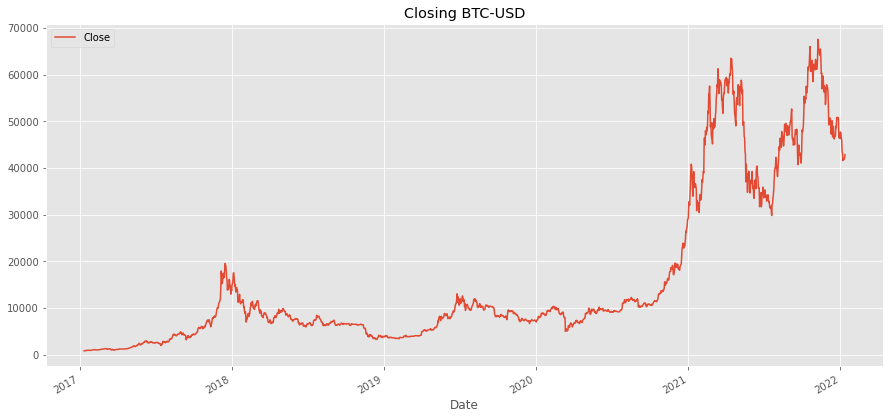

In [2]:
# Loading the dataset
p = '5y' #data from last 5 years
i = '1d' #daily

df = yf.download(tickers='BTC-USD', period = p, interval = i)
df.drop(df[df['Volume']==0].index, inplace = True)
df['Close'].plot(figsize=(15,7), title="Closing BTC-USD", legend=True)

In [37]:
df['Date_'] = df.index
df

date = pd.to_datetime('01/10/2022') - (pd.DateOffset(days=120)*2)
date

Timestamp('2021-05-15 00:00:00')

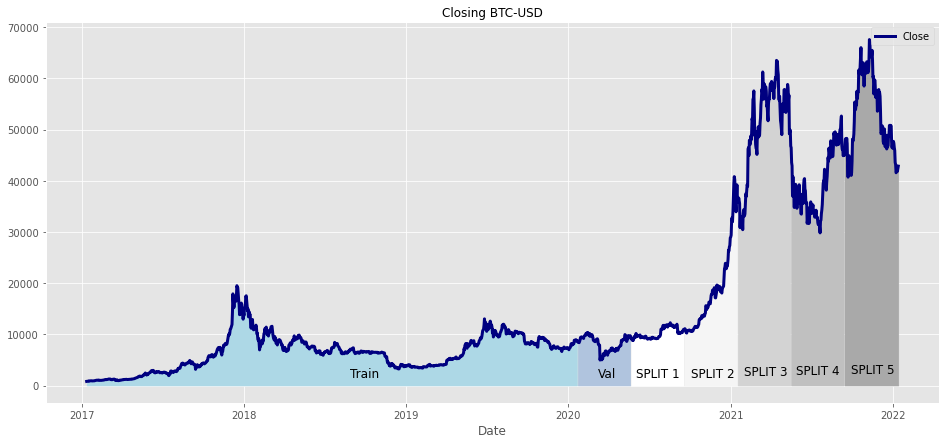

In [111]:
plt.figure(figsize = (16,7))
plt.plot( 'Date_', 'Close', data=df, color='navy', linewidth=3)
plt.title('Closing BTC-USD', fontsize=12)
plt.xlabel('Date', fontsize=12)

#Train
plt.fill_between(df['Date_'], df['Close'], 0, 
                 where = (df['Date_'] < pd.to_datetime('01/10/2022') - (pd.DateOffset(days=120)*6)),  
                 color = 'lightblue') 

#Val
plt.fill_between(df['Date_'], df['Close'], 0, 
                 where = (df['Date_'] > pd.to_datetime('01/10/2022') - (pd.DateOffset(days=120)*6)) 
                 & (df['Date_'] < pd.to_datetime('01/10/2022') - (pd.DateOffset(days=120)*5)),  
                 color = 'lightsteelblue') 
#Split 1
plt.fill_between(df['Date_'], df['Close'], 0, 
                 where = (df['Date_'] > pd.to_datetime('01/10/2022') - (pd.DateOffset(days=120)*5)) 
                 & (df['Date_'] < pd.to_datetime('01/10/2022') - (pd.DateOffset(days=120)*4)),  
                 color = 'white') 
#split 2
plt.fill_between(df['Date_'], df['Close'], 0, 
                 where = (df['Date_'] > pd.to_datetime('01/10/2022') - (pd.DateOffset(days=120)*4)) 
                 & (df['Date_'] < pd.to_datetime('01/10/2022') - (pd.DateOffset(days=120)*3)),  
                 color = 'whitesmoke') 
#split 3
plt.fill_between(df['Date_'], df['Close'], 0, 
                 where = (df['Date_'] > pd.to_datetime('01/10/2022') - (pd.DateOffset(days=120)*3)) 
                 & (df['Date_'] < pd.to_datetime('01/10/2022') - (pd.DateOffset(days=120)*2)),  
                 color = 'lightgray') 
#split 4
plt.fill_between(df['Date_'], df['Close'], 0, 
                 where = (df['Date_'] > pd.to_datetime('01/10/2022') - (pd.DateOffset(days=120)*2)) 
                 & (df['Date_'] < pd.to_datetime('01/10/2022') - (pd.DateOffset(days=120)*1)),  
                 color = 'silver') 
#split 5
plt.fill_between(df['Date_'], df['Close'], 0, where = (df['Date_'] > pd.to_datetime('01/10/2022') - (pd.DateOffset(days=120)*1)),  
                 color = 'darkgray') 

for x,y in zip(df['Date_'],df['Close']):
    if str(x) == "2018-09-30 00:00:00":
        plt.annotate("Train", (x,y-7000), textcoords="offset points", xytext=(0,10), size=12,ha='center') 
        
    if str(x) == "2020-03-28 00:00:00":
        plt.annotate('Val', (x,y-7000), textcoords="offset points", xytext=(0,12), size=12,ha='center') 
        
    if str(x) == "2020-07-20 00:00:00":
        plt.annotate("SPLIT 1", (x,y-9500), textcoords="offset points", xytext=(0,10), size=12,ha='center') 
        
    if str(x) == "2020-11-20 00:00:00":
        plt.annotate("SPLIT 2", (x,y-18900), textcoords="offset points", xytext=(0,10), size=12,ha='center') 
        
    if str(x) == "2021-03-20 00:00:00":
        plt.annotate("SPLIT 3", (x,y-58200), textcoords="offset points", xytext=(0,10), size=12,ha='center') 
        
    if str(x) == "2021-07-15 00:00:00":
        plt.annotate("SPLIT 4", (x,y-31500), textcoords="offset points", xytext=(0,10), size=12,ha='center') 
        
    if str(x) == "2021-11-15 00:00:00":
        plt.annotate("SPLIT 5", (x,y-63000), textcoords="offset points", xytext=(0,10), size=12,ha='center') 
        
plt.grid(True)
plt.legend()
plt.show()

### Pearson Correlation

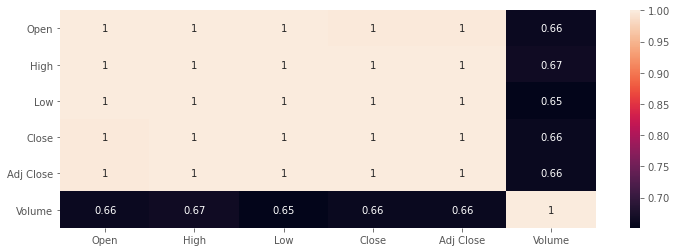

Open         0.998536
High         0.999363
Low          0.999240
Close        1.000000
Adj Close    1.000000
Volume       0.659856
Name: Close, dtype: float64

In [149]:
plt.figure(figsize=(12,4))
sns.heatmap(df.corr(), annot = True)

plt.show()
df.corr()['Close']

In [150]:
print(df.describe().Volume) 
df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0

count    1.826000e+03
mean     2.127380e+10
std      2.119017e+10
min      6.085170e+07
25%      4.662696e+09
50%      1.667075e+10
75%      3.278407e+10
max      3.509679e+11
Name: Volume, dtype: float64


In [151]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

## Model functions

In [152]:
# Function to transform data into sequential (LSTM)
def to_sequential_data(data, timesteps):
    x,y = [],[]
    for i in range(timesteps,data.shape[0]):
        x.append(data[i-timesteps:i])
        y.append(data[i])
    return np.array(x),np.array(y)

In [153]:
# Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    #Train and validation data
    X_train, Y_train = to_sequential_data(train, timesteps)
    X_val,Y_val = to_sequential_data(val, timesteps)
    
    # Add model layers
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]), return_sequences = True, activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
        model.add(Dropout(0.2))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')
  
    # Fit model
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']


In [154]:
# Function to evaluate the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop to the test data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    # Predict
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    mae = mean_absolute_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r2 = r2_score(Y_test,Y_hat)
    return mae, mse, rmse, r2, Y_test, Y_hat

In [155]:
# Function to plot the test and predict data
def plot_data(Y_test,Y_hat):
    plt.figure(figsize=(15,7))
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'g')
    plt.xlabel('Day')
    plt.ylabel('Closing')
    plt.title("Predict LSTM-M")
    plt.legend(['Actual','Predict'],loc = 'lower right')
    plt.show()

In [156]:
# Function to plot error
def plot_error(train_loss,val_loss):
    plt.figure(figsize=(15,7))
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

### Building model

In [157]:
# Extracting the series
features = ['Close', 'Open', 'Low', 'High']
series = df[features]
print(series.shape)
print(series.tail())

(1826, 4)
                   Close          Open           Low          High
Date                                                              
2022-01-06  43160.929688  43565.511719  42645.539062  43748.718750
2022-01-07  41557.902344  43153.570312  41077.445312  43153.570312
2022-01-08  41733.941406  41561.464844  40672.277344  42228.941406
2022-01-09  41911.601562  41734.726562  41338.160156  42663.949219
2022-01-11  41662.507812  41778.222656  41662.507812  41781.894531


In [158]:
# Splitting in train, validation and test
qt_test = 120

train_data =  series.iloc[:-(qt_test*2),]
val_data = series.iloc[-(qt_test*2):-qt_test,]
test_data = series.iloc[-qt_test:]

print(train_data.shape,val_data.shape,test_data.shape)

(1586, 4) (120, 4) (120, 4)


In [159]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(1586, 4) (120, 4) (120, 4)


In [160]:
# Inverse normalisation
close_scale = 1/sc.scale_[0]
close_scale

62725.70001220703

### Hyperparameters
These values were obtained empirically

In [161]:
timesteps = 2
hl = [50, 80, 130, 210]
lr = 1e-3
batch_size = 128
num_epochs = 250

Epoch 00172: early stopping


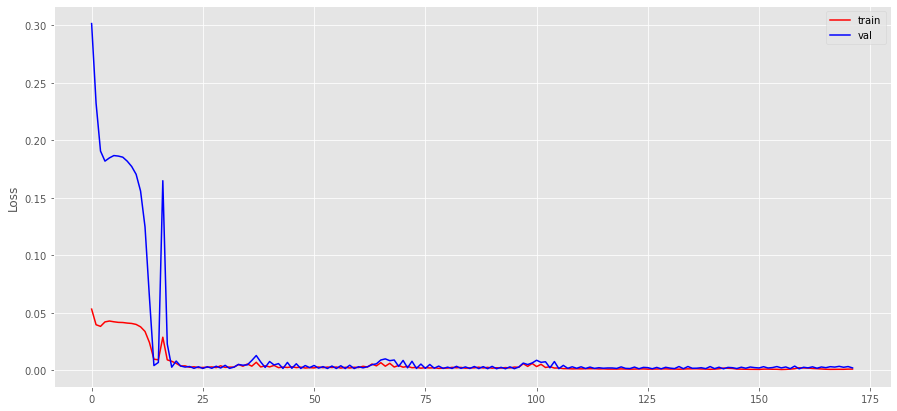

In [162]:
model,train_error,val_error = fit_model(train, val, timesteps, hl, lr, batch_size, num_epochs)
plot_error(train_error,val_error)

R2 = 0.7200273475351173
MAE = 0.05054539082416684
MSE = 0.003910804491719225
RMSE = 0.0625364253193227


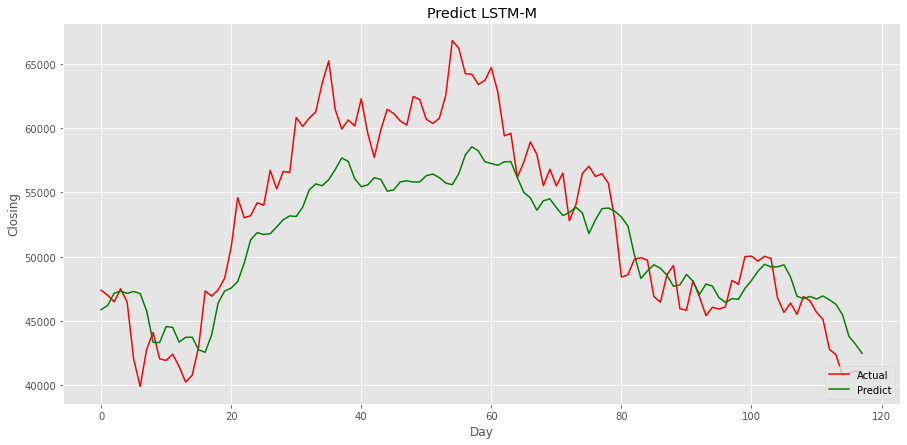

In [163]:
mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('R2 = {}'.format(r2_value))
print('MAE = {}'.format(mae))
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
plot_data(true*close_scale,predicted*close_scale)

## Validação Cruzada

In [164]:
# num_epochs optimized
num_epochs = 80

In [165]:
# Extracting the series
series = df[features]
print(series.shape)
print(series.tail())

(1826, 4)
                   Close          Open           Low          High
Date                                                              
2022-01-06  43160.929688  43565.511719  42645.539062  43748.718750
2022-01-07  41557.902344  43153.570312  41077.445312  43153.570312
2022-01-08  41733.941406  41561.464844  40672.277344  42228.941406
2022-01-09  41911.601562  41734.726562  41338.160156  42663.949219
2022-01-11  41662.507812  41778.222656  41662.507812  41781.894531


In [166]:
# Normalisation
sc = MinMaxScaler()
series = sc.fit_transform(series[:series.shape[0]])
series

array([[0.00000000e+00, 1.99083332e-03, 1.06802189e-04, 1.41453876e-03],
       [4.05410120e-04, 0.00000000e+00, 0.00000000e+00, 4.32414898e-05],
       [6.92134042e-04, 4.27693159e-04, 3.69470881e-04, 8.37763453e-05],
       ...,
       [6.13216859e-01, 6.10805808e-01, 6.08239645e-01, 6.09208143e-01],
       [6.15876877e-01, 6.13400534e-01, 6.18386228e-01, 6.15608487e-01],
       [6.12147319e-01, 6.14051922e-01, 6.23328571e-01, 6.02630667e-01]])

In [167]:
# Inverse normalisation testing
close_scale = 1/sc.scale_[0]
close_scale

66789.07110595703

### Function for forward walk cross validation using batch

In [168]:
# Function for forward walk cross validation using batch
def cross_val_forward_walk_batch(splits, split_size, series):
    cross_val_results = list()
    # Loop to evaluate every batch split
    for i in range(splits):
        train = series[:(3+i)*split_size]
        test = series[(3+i)*split_size:(4+i)*split_size]
        X_train,Y_train = to_sequential_data(train, timesteps)
        start = time.time()
        history = model.fit(X_train,Y_train,epochs = num_epochs,batch_size = batch_size,validation_split = 0.2,verbose = 0,shuffle = False)
        end = time.time()  
        # Evalute and plot the results
        mae, mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
        print("SPLIT "+str(i+1))
        print('R2 = {}'.format(r2_value))
        print('MAE = {}'.format(mae))
        print('MSE = {}'.format(mse))
        print('RMSE = {}'.format(rmse))
        plot_data(true*close_scale,predicted*close_scale)
        cross_val_results.append([mae, mse,rmse,r2_value,end-start])
    return cross_val_results

### Cross validation results

SPLIT 1
R2 = 0.6622492957521733
MAE = 0.011466656820127069
MSE = 0.0002753613814571203
RMSE = 0.01659401643536369


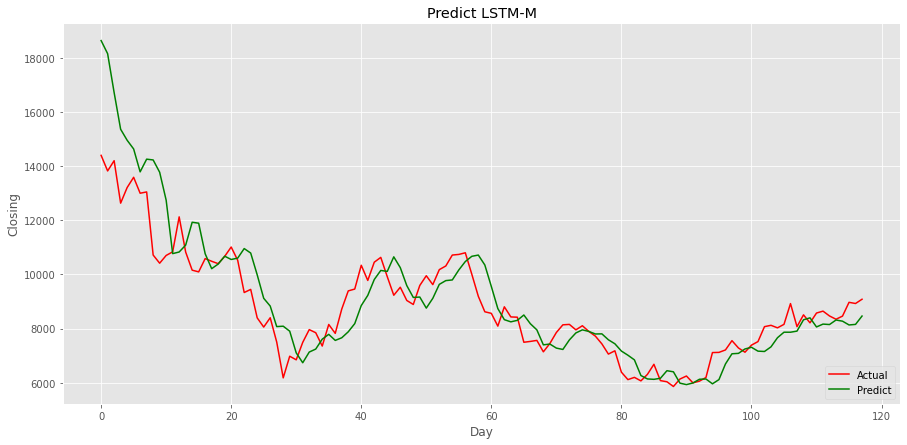

SPLIT 2
R2 = 0.7848980922686783
MAE = 0.004154930183193024
MSE = 3.019155789538255e-05
RMSE = 0.005494684512816232


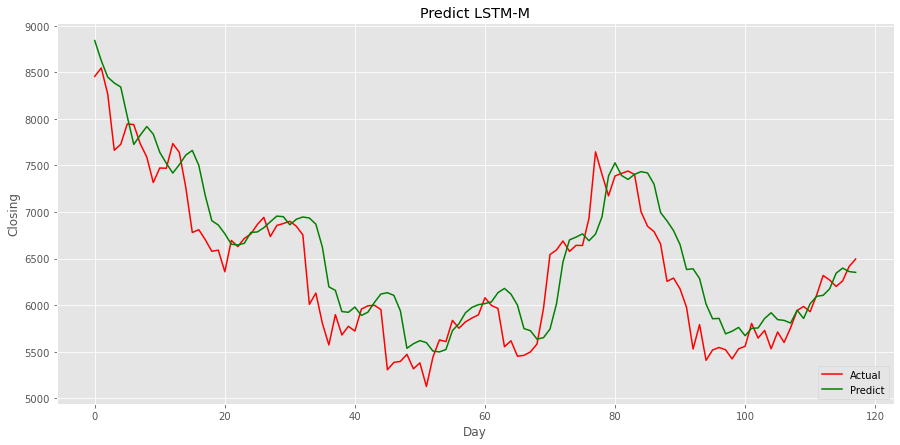

SPLIT 3
R2 = 0.9181971564345257
MAE = 0.004214494488619706
MSE = 2.953398309198593e-05
RMSE = 0.005434517742356347


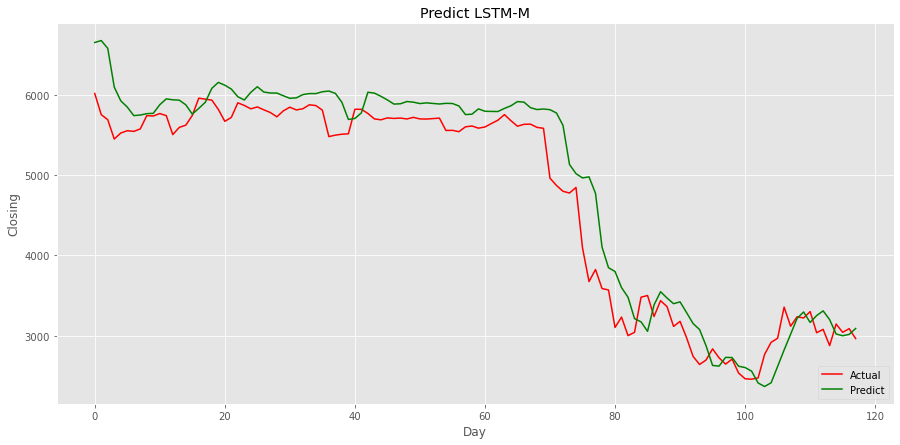

SPLIT 4
R2 = 0.9342035563972101
MAE = 0.0015072557940047527
MSE = 6.029094004054793e-06
RMSE = 0.002455421349596601


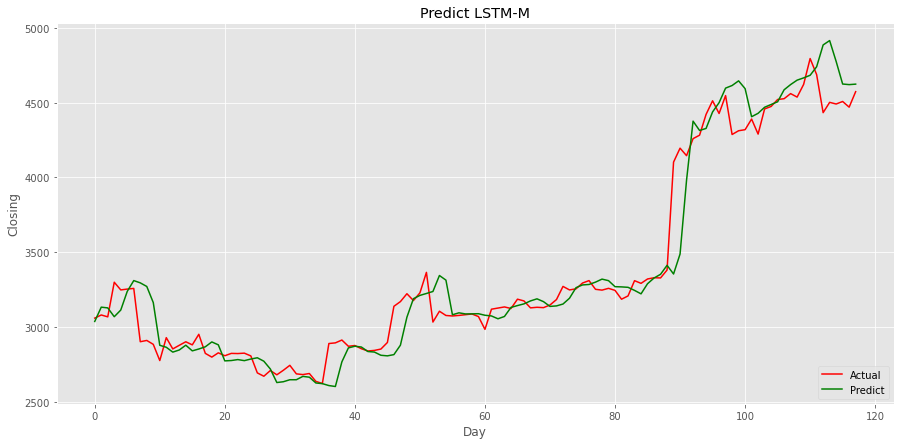

SPLIT 5
R2 = 0.8683799130779215
MAE = 0.007337400633340888
MSE = 8.70791573367777e-05
RMSE = 0.009331621366985359


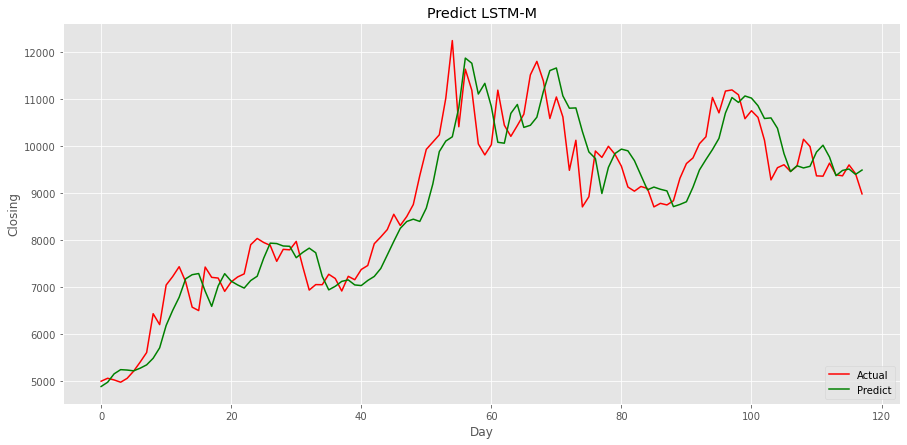

In [169]:
# Call the cross validation function
splits = 5
split_size = 120
cross_val_results = cross_val_forward_walk_batch(splits,split_size, series)

In [170]:
# Getting performance average from metrics
CV_temp = pd.DataFrame(cross_val_results,columns=['MAE', 'MSE','RMSE','R2_Score','Train_Time'])
print("Média R2 = {}".format(CV_temp['R2_Score'].mean()))
print("Média MAE = {}".format(CV_temp['MAE'].mean()))
print("Média MSE = {}".format(CV_temp['MSE'].mean()))
print("Média RMSE = {}".format(CV_temp['RMSE'].mean()))

Média R2 = 0.8335856027861018
Média MAE = 0.005736147583857088
Média MSE = 8.563903475706426e-05
Média RMSE = 0.007862052281423646
